# Relevant Tweets Filter

In this notebook we build a classifier that recognizes which tweets are related to the stock of the company and which are just spam.

The classifier would be a simple Bi-Directional LSTM train for very few epochs due to the limited amount of data.

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My Drive/Data

/content/drive/My Drive/Data


## Download all the dependencies

In [ ]:
!mkdir tweet_data

Skip this if you have already download all the dependencies

In [ ]:
# Download the glove embedding

#!wget http://nlp.stanford.edu/data/glove.42B.300d.zip
#!unzip glove.42B.300d.zip

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2019-12-08 20:26:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-12-08 20:26:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-12-08 20:26:07--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# !python -m gensim.scripts.glove2word2vec -i glove.42B.300d.txt -o glove.42B.300d.word2vec.txt
!python -m gensim.scripts.glove2word2vec -i glove.6B.300d.txt -o glove.6B.300d.word2vec.txt

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'gensim.scripts.glove2word2vec' found in sys.modules after import of package 'gensim.scripts', but prior to execution of 'gensim.scripts.glove2word2vec'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2019-12-08 20:46:02,945 - glove2word2vec - INFO - running /usr/local/lib/python3.6/dist-packages/gensim/scripts/glove2word2vec.py -i glove.6B.300d.txt -o glove.6B.300d.word2vec.txt
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-12-08 20:46:03,989 - glove2word2vec - INFO - converting 400000 vectors from glove.6B.300d.txt to glove.6B.300d.word2vec.txt
2019-12-08 20:46:08,336 - glove2word2vec - INFO - Converted mo

# Start Coding

In [ ]:
import os
import glob
import numpy as np
import email
import pandas as pd

# Load the data

In [ ]:
tweets_df = pd.read_csv('moodstock_data/MoodstockDataset_Relevant-Irrelevant_Tweets.csv', sep=',', index_col='db_id')
tweets_df.drop(['Original Text'], axis=1, inplace=True)
tweets_df = tweets_df.dropna()
tweets_df.head()

,label,Tweet,Sentiment,Objetive/Subjective
db_id,,,,
0,0.0,FB high OI range is to for opti...,0,0.540000
1,-1.0,Is Facebook Doubling Down on Virtual Reality ...,-1,0.288889
2,-1.0,markfidelman What Zuckerberg Should Have Tol...,-1,0.000000
3,-1.0,What Zuckerberg Should Have Told Congress Abou...,-1,0.000000
4,0.0,Facebook Inc FB Given Average Rating of Bu...,1,0.400000


### Create Lables

We make two labels, to keep or to discard a tweet. Since in the original data `0` means keep and `-1` means the tweet is not relevant we would use it as it is but we convert the `-1` to `1`. There are some of them which are labeled -2. This means they are relevant but with wrong sentiment so we make them be part of the `0` class.

| label| meaning    |
|------|------------|
|  0   | relevant   |
|  1   | not relevant|


In [ ]:
tweets_df['label'] = tweets_df['label'].replace({-1:1, -2:0})
tweets_df.head()

,label,Tweet,Sentiment,Objetive/Subjective
db_id,,,,
0,0.0,FB high OI range is to for opti...,0,0.540000
1,1.0,Is Facebook Doubling Down on Virtual Reality ...,-1,0.288889
2,1.0,markfidelman What Zuckerberg Should Have Tol...,-1,0.000000
3,1.0,What Zuckerberg Should Have Told Congress Abou...,-1,0.000000
4,0.0,Facebook Inc FB Given Average Rating of Bu...,1,0.400000


In [ ]:
x = tweets_df['Tweet'].values
y = tweets_df['label'].values

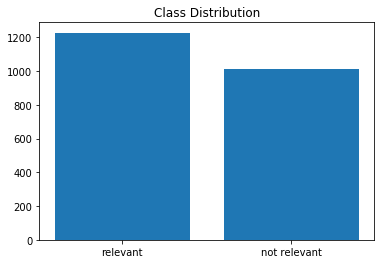

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

unique_labels = np.unique(y, return_counts=True)
plt.bar(['relevant', 'not relevant'],unique_labels[1])
plt.title('Class Distribution')
plt.show()

# Split data into train/test

Make a stratified split to ensure equal distribution of the samples from each class.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y, test_size=0.25)

Shuffle the data for better results

In [ ]:
# Train
train_shuffle_index = np.random.permutation(np.arange(0,x_train.shape[0]))

x_train = x_train[train_shuffle_index]
y_train = y_train[train_shuffle_index]

# Test
test_shuffle_index = np.random.permutation(np.arange(0,x_test.shape[0]))

x_test = x_test[test_shuffle_index]
y_test = y_test[test_shuffle_index]

# Preprocessing

Now we have to preprocess the data using the following techniques:


*   remove urls
*   convert words to lower case
*   remove numbers
*   remove punctuation
*   remove white spaces
*   replace new line character ('\n')
*   removing stop words a, the, and so on…



## Process sentence

In [ ]:
import re
import string
from nltk.tokenize import word_tokenize


In [ ]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

In [ ]:
def to_lower(word):
    result = word.lower()
    return result

In [ ]:
def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

In [ ]:
def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

In [ ]:
def remove_whitespace(word):
    return word.strip()

In [ ]:
def replace_newline(word):
    return word.replace('\n','')

In [ ]:
def clean_up_pipeline(sentence):
    cleaning_utils = [
                    remove_hyperlink,
                    replace_newline,
                    to_lower,
                    remove_number,
                    remove_punctuation,
                    remove_whitespace
                ]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

In [ ]:
x_train = [clean_up_pipeline(o) for o in x_train]
x_test = [clean_up_pipeline(o) for o in x_test]

In [ ]:

x_train[0]

'wmt s price moved above its    day moving average on november           view odds for this and other indicators    walmart  stockmarket  stock  technicalanalysis  money  trading  investing  daytrading  news  today'

## Process word by word

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
x_train = [word_tokenize(o) for o in x_train]
x_test = [word_tokenize(o) for o in x_test]

In [ ]:
def remove_stop_words(words):
    result = [i for i in words if i not in ENGLISH_STOP_WORDS]
    return result

In [ ]:
def word_stemmer(words):
    return [stemmer.stem(o) for o in words]

In [ ]:
def word_lemmatizer(words):
    return [lemmatizer.lemmatize(o) for o in words]

In [ ]:
def clean_token_pipeline(words):
    cleaning_utils = [remove_stop_words,word_lemmatizer]
    for o in cleaning_utils:
        words = o(words)
    return words

In [ ]:
x_train = [clean_token_pipeline(o) for o in x_train]
x_test = [clean_token_pipeline(o) for o in x_test]

In [ ]:
x_train[1]

['group',
 'daily',
 'technical',
 'video',
 'ready',
 'member',
 'covering',
 'instrument',
 'technical',
 'market',
 'xom',
 'key',
 'elliottwave',
 'trading']

# Extract Features from Words

## Use Glove Pretrain

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [ ]:
maxlen = 300
max_features = 50000

In [ ]:
EMBEDDING_FILE = 'glove.6B.300d.txt'
tokenizer = Tokenizer(num_words=max_features)

In [ ]:
tokenizer.fit_on_texts(x_train)

In [ ]:
x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features = pad_sequences(x_train_features,maxlen=maxlen)
x_test_features = pad_sequences(x_test_features,maxlen=maxlen)

In [ ]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

    
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
from keras.initializers import Constant

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index)+1)


embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features,
              embed_size,
            #   weights=[embedding_matrix],
              embeddings_initializer=Constant(embedding_matrix),
              input_length=maxlen,
              trainable=False
              )(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300, 128)          140544    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_____________________________________________

In [ ]:
history = model.fit(x_train_features,y_train, batch_size=128, epochs=20)



Epoch 1/20
1680/1680 [==============================] - 4s 3ms/step - loss: 0.6558 - acc: 0.6101
Epoch 2/20
1680/1680 [==============================] - 1s 307us/step - loss: 0.5439 - acc: 0.7649
Epoch 3/20
1680/1680 [==============================] - 1s 307us/step - loss: 0.4809 - acc: 0.7917
Epoch 4/20
1680/1680 [==============================] - 1s 311us/step - loss: 0.4397 - acc: 0.8089
Epoch 5/20
1680/1680 [==============================] - 1s 311us/step - loss: 0.4040 - acc: 0.8280
Epoch 6/20
1680/1680 [==============================] - 1s 308us/step - loss: 0.3777 - acc: 0.8321
Epoch 7/20
1680/1680 [==============================] - 1s 308us/step - loss: 0.3503 - acc: 0.8577
Epoch 8/20
1680/1680 [==============================] - 1s 307us/step - loss: 0.3200 - acc: 0.8726
Epoch 9/20
1680/1680 [==============================] - 1s 309us/step - loss: 0.2896 - acc: 0.8821
Epoch 10/20
1680/1680 [==============================] - 1s 303us/step - loss: 0.2675 - acc: 0.9054
Epoch 11/

In [ ]:
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Neural Network w Embedding From Scratch

In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [ ]:
tokenizer = Tokenizer(num_words=max_feature)

In [ ]:
tokenizer.fit_on_texts(x_train)

In [ ]:
x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

In [ ]:
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)

In [ ]:
embed_size = 100

inp = Input(shape=(max_len,))
x = Embedding(max_feature, embed_size)(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 2000, 100)         5000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 2000, 128)         63744     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

In [ ]:
history = model.fit(x_train_features, y_train, batch_size=512, epochs=20, validation_data=(x_test_features, y_test))

Train on 3795 samples, validate on 1281 samples
Epoch 1/20
3795/3795 [==============================] - 9s 2ms/step - loss: 0.6305 - acc: 0.7937 - val_loss: 0.5624 - val_acc: 0.7916
Epoch 2/20
3795/3795 [==============================] - 8s 2ms/step - loss: 0.5221 - acc: 0.7950 - val_loss: 0.4889 - val_acc: 0.7916
Epoch 3/20
3795/3795 [==============================] - 8s 2ms/step - loss: 0.4808 - acc: 0.7950 - val_loss: 0.4699 - val_acc: 0.7916
Epoch 4/20
3795/3795 [==============================] - 8s 2ms/step - loss: 0.4458 - acc: 0.7950 - val_loss: 0.4278 - val_acc: 0.7916
Epoch 5/20
3795/3795 [==============================] - 8s 2ms/step - loss: 0.3939 - acc: 0.7950 - val_loss: 0.3608 - val_acc: 0.7916
Epoch 6/20
3795/3795 [==============================] - 8s 2ms/step - loss: 0.2967 - acc: 0.8274 - val_loss: 0.2337 - val_acc: 0.8813
Epoch 7/20
3795/3795 [==============================] - 8s 2ms/step - loss: 0.1575 - acc: 0.9505 - val_loss: 0.1181 - val_acc: 0.9828
Epoch 8/20
379

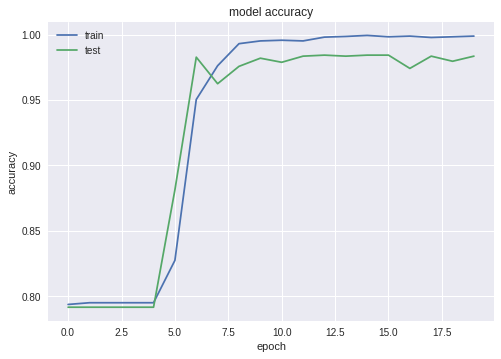

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score,accuracy_score

In [ ]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [ ]:
confusion_matrix(y_test,y_predict)

array([[251,  56],
       [ 72, 181]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()

In [ ]:
print("Accuracy: {:.2f}%".format(100*accuracy_score(y_test,y_predict)))
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))

Accuracy: 77.14%
Precision: 76.37%
Recall: 71.54%


In [ ]:
f1_score(y_test,y_predict)

0.7387755102040815



### Plot confusion matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

cnf_matrix = confusion_matrix(y_test,y_predict)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[251  56]
 [ 72 181]]


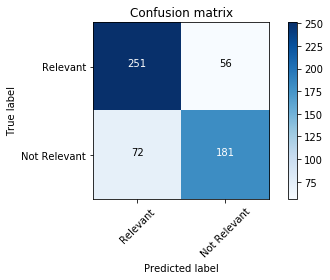

In [ ]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Relevant','Not Relevant'], normalize=False,
                      title='Confusion matrix')

In [ ]:
wrong_idx = np.where(y_test != y_predict)[0]

# Error Analysis on Unlabeled Tweets 

In [ ]:
all_tweets_df = pd.read_csv('moodstock_data/MoodstockDataset_0-10k.csv', sep=';', index_col='db_id')
all_tweets_df.head()

,Tweet,Sentiment,Objetive/Subjective
db_id,,,
0,FB high OI range is to for opti...,0,0.540000
1,Is Facebook Doubling Down on Virtual Reality ...,-1,0.288889
2,markfidelman What Zuckerberg Should Have Tol...,-1,0.000000
3,What Zuckerberg Should Have Told Congress Abou...,-1,0.000000
4,Facebook Inc FB Given Average Rating of Bu...,1,0.400000


In [ ]:
subsample = np.random.randint(2500, 8000, 30)
x_tweets = all_tweets_df.iloc[subsample]['Tweet'].values

In [ ]:
# Create x_tweets, y_tweets

# Sentence clean-up
x_tweets = [clean_up_pipeline(o) for o in x_tweets]
# Word clean-up
x_tweets = [word_tokenize(o) for o in x_tweets]
x_tweets = [clean_token_pipeline(o) for o in x_tweets]


# Extract features
x_tweets_features = np.array(tokenizer.texts_to_sequences(x_tweets))
x_tweets_features = pad_sequences(x_tweets_features,maxlen=maxlen)

In [ ]:
y_predict_tweets  = [1 if o>0.5 else 0 for o in model.predict(x_tweets_features)]

result = pd.DataFrame(zip(all_tweets_df.iloc[subsample]['Tweet'].values, y_predict_tweets))
result.values

array([[' DIS Disney new ATH', 1],
       [' SwanniOnTV  HedgeyeComm  MasterPhoFooga  Here s a fun question for everyone w  this chain in mind  how soon before  DIS offers free Disney  subscriptions with Disney Theme Park packages  If they re stressing  sign ups  this early they have to be favjng bearish internal projections about  subscribers ',
        1],
       [' TSLA   Tesla Cybertruck Peak Craziness  Sign up for updates on Seeking Alpha    investing  economy  stockmarket',
        0],
       [' AMZN Update continues to lift off major support      amazon Amazon  qqq  spx  twows ',
        1],
       ['Disney  Many Moving Parts Fall In Places  DIS ', 0],
       [' PG now     from     ', 0],
       ['Why private college closures are on the rise  TSLA  ', 0],
       [' DIS its not that often you see massive accumulation in Mega cap stocks  Disney is showing it over the last few months      Note the huge sell bar and volume back in       the stock went nowhere for   years after  The 

In [ ]:
result.to_csv('test.csv')

In [ ]:
!ls

datasets		     glove.6B.300d.txt		 test.csv
glove.42B.300d.txt	     glove.6B.300d.word2vec.txt  tweet_data
glove.42B.300d.word2vec.txt  glove-embeddings.csv
